In [1]:
!pip install ta
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch
import ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=243910ca956d41a178cdfac508755e857551cd7e8711a68b62de5642adfd6e46
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
data = pd.read_csv('appl_day_data0.csv')

In [3]:
rows = data.shape[0]

Past prediction is not an indicator for future outcome
Data:
*   Normalize to Z-Standardization
*   Stagger Data?
*   Create sequence

Inputs:
  Volume: higher volume = greater chance of movement
  RSI
  MA

NeuralNet(nn.modele) creates a class called NeuralNet that inherits from nn.Module
nn.Module is a base class for neural network modules in PyTorch

__init__ initializes the neural network with parameters input_size, hidden_size, and output_size
  each parameter defines how many neurons in each layer

self.l1: takes input_size number of inputs and produces hidden_size outputs
self.sigmoid: activation function that converts the output of self.l1
 converts the outputs into numbers bt 0 and 1
self.l2: takes hidden_size inputs and produces output_size outputs
self.relu: another activation function; negative values turn to 0

forward: defines how data moves through the network
 applies first layer, then sigmoid, then second layer, then relu
 returns the output at the end

training:
criterion: defines the loss function that measures the difference bt predicted and actual values
 we use Mean Squared Error (like from regression)
optimizer: sets up the Adam optimizer; adjusts the weights during training
 learning rate (lrn) controls how much the weights are updated
training loop:
 outer loop runs for specified epochs (full passes through dataset)
 inner loop goes through each example in dataset
 forward pass: computes output using forward method
 loss: calculates the loss (from criterion)
 optimizer.zero_grad(): clears previous gradients
 loss.backward(): calculates gradients of the loss with respect to model paramters
 optimizer.step(): updated model parameters based on gradients

we calculate loss to see how well the model is performing
 loss is how far output is from train_dataset
 small loss is better performance

we clear gradients from previous iteration. gradients don't clear up from iteration to it.
loss.backward(): uses backpropogation to compute loss with respect to each model parameter
 allows each neuron weight to be adjusted based on its contribution to the loss
optimizer.step(): updated models parameters based on gradients
 means that we change the weights in a direction that minimizes the loss


Things to think about for improvement:

Batch Training:
 Processs several examples simulatensouly to improve training speed and convergence

Learning Rate Scheduling
 Adjust the learning rate during training can help model converge more effectively

Regularization:
 dropout: drop random neurons to promote robustness
 add penalties to the loss function for larger weights

add more layers

##Actual Code

In [4]:
#MODEL
class NeuralNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
      super(NeuralNet, self).__init__()
      self.l1 = nn.Linear(input_size, hidden_size)
      self.tan = nn.Tanh()
      self.l2 = nn.Linear(hidden_size, output_size)
      self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      x = x.view(x.size(0), -1)
      out = self.l1(x)
      out = self.tan(out)
      out = self.l2(out)
      out = self.softmax(out)
      return out

    def train_model(self, epochs, lrn, train_loader):
      #using Binary Cross Entropy Loss bc it works well with probabilities
      #I can also try CrossEntropyLoss that woeks with softmax layer
      # remove softmax in model to use
      # uses a negative log-likelihood loss which is more numerically stable
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(self.parameters(), lr=lrn)

      for epoch in range(epochs):
        #train_loader because we're working in batches
        for inputs, targets in train_loader:
          #forward
          output = self(inputs)
          loss = criterion(output, targets)

          #backwards
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        #Print the loss to monitor the progress
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [5]:
#DATA
#Preporocess data by scaling it (between 0 and 1 using MinMaxScaler)
from sklearn.model_selection import train_test_split


#cleaning the data (converting to numbers)
data['Close/Last'] = data['Close/Last'].replace({'\$': '', ',': ''}, regex=True).astype(float)
data['Open'] = data['Open'].replace({'\$': '', ',': ''}, regex=True).astype(float)
data['High'] = data['High'].replace({'\$': '', ',': ''}, regex=True).astype(float)
data['Low'] = data['Low'].replace({'\$': '', ',': ''}, regex=True).astype(float)

#10 day rolling average
data['MA10'] = data['Close/Last'].rolling(window=10).mean()

#RSI
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close/Last'], window=14).rsi()

#Droping NA values
data = data[['Open', 'Close/Last', 'High', 'Low', 'MA10', 'RSI']].dropna()

#Scaling data to Z-Standard
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = scaled_data * 2

X = scaled_data[:-1]  # All rows except the last one
y = (scaled_data[1:, 1] > scaled_data[:-1, 1]).astype(int)  # Compare today's closing with tomorrow's
y = np.column_stack([y, 1 - y])  # One-hot encoding: [1, 0] for up, [0, 1] for down

# Step to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
x_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
x_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoader for the training set
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)

In [6]:
# 3. Initialize the model
input_size = 6  # 12 days * 6 features
hidden_size = 6  # You can experiment with this
output_size = 2  # Up/Down prediction

model = NeuralNet(input_size, hidden_size, output_size)

# 4. Train the model
epochs = 350
learning_rate = 0.006

model.train_model(epochs, learning_rate, train_loader)

Epoch [1/350], Loss: 0.7475
Epoch [2/350], Loss: 0.6241
Epoch [3/350], Loss: 0.6688
Epoch [4/350], Loss: 0.6548
Epoch [5/350], Loss: 0.6508
Epoch [6/350], Loss: 0.8184
Epoch [7/350], Loss: 0.6692
Epoch [8/350], Loss: 0.6753
Epoch [9/350], Loss: 0.6865
Epoch [10/350], Loss: 0.6994
Epoch [11/350], Loss: 0.8195
Epoch [12/350], Loss: 0.6563
Epoch [13/350], Loss: 0.8308
Epoch [14/350], Loss: 0.6947
Epoch [15/350], Loss: 0.6232
Epoch [16/350], Loss: 0.6246
Epoch [17/350], Loss: 0.6163
Epoch [18/350], Loss: 0.5972
Epoch [19/350], Loss: 0.5672
Epoch [20/350], Loss: 0.6896
Epoch [21/350], Loss: 0.6079
Epoch [22/350], Loss: 0.7543
Epoch [23/350], Loss: 0.6003
Epoch [24/350], Loss: 0.7650
Epoch [25/350], Loss: 0.6777
Epoch [26/350], Loss: 0.7545
Epoch [27/350], Loss: 0.6490
Epoch [28/350], Loss: 0.7277
Epoch [29/350], Loss: 0.7354
Epoch [30/350], Loss: 0.7212
Epoch [31/350], Loss: 0.7891
Epoch [32/350], Loss: 0.6784
Epoch [33/350], Loss: 0.6565
Epoch [34/350], Loss: 0.6321
Epoch [35/350], Loss: 0

In [7]:
def evaluate_model(model, x_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(x_test)  # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability

        _, labels = torch.max(y_test_tensor, 1)  # Convert one-hot to single label

        accuracy = (predicted == labels).float().mean()  # Calculate accuracy
        return accuracy.item()

# Check accuracy on the test set
accuracy = evaluate_model(model, x_test_tensor, y_test_tensor)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 71.46%


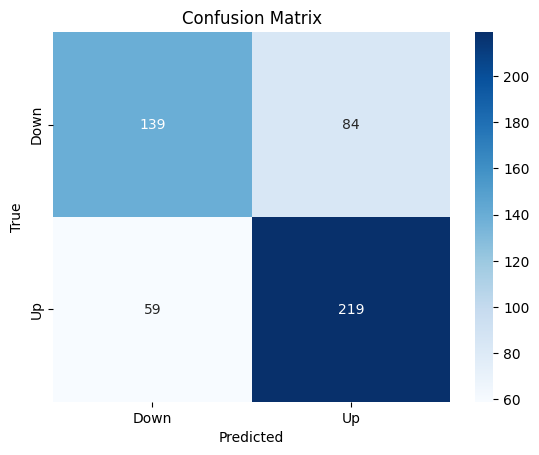

In [8]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(x_test)
        _, predicted = torch.max(outputs, 1)
        _, true_labels = torch.max(y_test, 1)

        # Compute confusion matrix
        cm = confusion_matrix(true_labels.numpy(), predicted.numpy())

        # Plot the confusion matrix using seaborn
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

# Call the function to plot confusion matrix
plot_confusion_matrix(model, x_test_tensor, y_test_tensor)


#The outputs of True Positive and True Negatives are much higher than others

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_classification_metrics(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(x_test)
        _, predicted = torch.max(outputs, 1)
        _, true_labels = torch.max(y_test, 1)

        # Calculate precision, recall, and F1-score
        precision = precision_score(true_labels.numpy(), predicted.numpy())
        recall = recall_score(true_labels.numpy(), predicted.numpy())
        f1 = f1_score(true_labels.numpy(), predicted.numpy())

        return precision, recall, f1

# Get classification metrics
precision, recall, f1 = evaluate_classification_metrics(model, x_test_tensor, y_test_tensor)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.7228
Recall: 0.7878
F1 Score: 0.7539


In [ ]:
def test_on_new_input(model, custom_input):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        custom_input_tensor = torch.FloatTensor(custom_input).unsqueeze(0)  # Ensure it's a batch (1 sample)
        output = model(custom_input_tensor)  # Get model output
        _, predicted = torch.max(output, 1)  # Get class with highest probability

        return predicted.item()  # Return the predicted class index

# Example custom input: scaled values for Open, Close, High, Low, MA10, RSI (assuming scaling is done the same way as training data)
custom_input = [0.5, 0.3, 0.7, 0.6, 0.8, 0.4]  # Example custom data (normalized/scaled)
prediction = test_on_new_input(model, custom_input)

print(f'Predicted class for custom input: {"Up" if prediction == 1 else "Down"}')


Predicted class for custom input: Down


In [10]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Step 1: Assuming the model and scaler are already trained and fitted on training data
# Example for the model and scaler (in case it's not already done)
# For this example, we assume 'scaler' was fitted on the training data (as in previous examples)

# Assuming you have a trained model called 'model' and a fitted scaler called 'scaler'
# Also assuming you have 'input_size' and 'output_size' already defined

# Let's define a function that normalizes new real-world data

def normalize_and_predict(raw_data, model, scaler):
    """
    Takes raw real-world input data, normalizes it using the training data's scaler,
    and then inputs it into the trained model to predict the outcome.

    Parameters:
    - raw_data: pd.DataFrame, raw real-world data (e.g., stock data) to be normalized.
    - model: The trained PyTorch neural network model.
    - scaler: The StandardScaler fitted on training data to normalize the data.

    Returns:
    - predictions: The model's predictions for the input data.
    """
    # Step 1: Normalize the new raw data using the fitted scaler (from training)
    # Ensure that the raw data columns match the columns used during training
    raw_data_scaled = scaler.transform(raw_data)

    # Step 2: Convert the scaled data to PyTorch tensor
    raw_data_tensor = torch.FloatTensor(raw_data_scaled)

    # Step 3: Use the trained model to predict the outcome
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to calculate gradients during prediction
        predictions = model(raw_data_tensor)

    return predictions

# Example usage:

# Step 1: Define the real-world data you want to test
# This should have the same feature columns as the training data
new_data = pd.DataFrame({
    'Open': [223.58],  # Real-world raw data for 'Open' prices
    'Close/Last': [222.50],
    'High': [224.04],
    'Low': [221.91],
    'MA10': [222.50],
    'RSI': [55.1]
})

# Step 2: Normalize and get predictions
predictions = normalize_and_predict(new_data, model, scaler)

# Step 3: Print out the predictions
print("Predictions:")
print(predictions)


Predictions:
tensor([[0.9734, 0.0266]])
